## 1. Data preprocessing

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
import transformers
import tensorflow as tf
from transformers import BertTokenizerFast
from transformers import TFBertForSequenceClassification
# from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Data load
data = pd.read_csv("/home/tech/Hawon/Input 데이터(final_fooddata + 역번역데이터 합본).csv")
data = data.rename(columns={'메뉴명':"menu", '설명':"content"})
data = data[['menu', 'content']]
data.head(3)

,menu,content
0,갈비찜,소갈비를 이용한 한국 요리
1,갈비찜,명절이나 잔칫상에 올라가는 음식이다
2,갈비찜,이것 또한 밥도둑 반찬이며 입맛이 없을때 먹기 좋은 음식이다.


In [3]:
# Label sort
data = data.sort_values(by=['menu'])
data = data.reset_index(drop=True)
data.menu.unique()

array(['갈비찜', '갈비탕', '감바스', '감자전', '감자탕', '게장', '고등어구이', '곰탕', '곱창',
       '곱창구이', '국밥', '김밥', '김치전', '김치찌개', '김치찜', '깐쇼새우', '깐풍기', '꼬치',
       '꼼장어구이', '꽁치구이', '꽃게탕', '나베', '낙지볶음', '난자완스', '내장탕', '냉면', '닭갈비',
       '닭껍질튀김', '닭도리탕', '닭똥집', '닭발', '대하', '덮밥', '도가니탕', '도토리묵', '돈가스',
       '돌솥비빔밥', '돼지갈비', '돼지불고기', '된장찌개', '떡갈비', '떡국', '떡만두국', '떡만둣국',
       '떡볶이', '또띠아', '라멘', '라면', '라볶이', '라조기', '리소토', '리조또', '마라탕',
       '마파두부', '막국수', '막창', '만두', '매운탕', '메밀국수', '물회', '밀면', '백숙', '보쌈',
       '볶음밥', '볶음우동', '부대찌개', '북엇국', '분짜', '불고기', '비빔국수', '비빔밥', '비지',
       '빈대떡', '빵', '사골국', '삼겹살', '삼계탕', '샌드위치', '샐러드', '생선구이', '생선까스',
       '샤브샤브', '설렁탕', '소바', '수제비', '순대', '순대국', '순두부', '순두부찌개', '스테이크',
       '스파게티', '쌀국수', '아귀찜', '알밥', '알탕', '양장피', '어묵탕', '연어', '오뎅', '오리고기',
       '오므라이스', '오징어순대', '우동', '월남쌈', '유산슬', '육회', '잔치국수', '잡채밥', '장어구이',
       '전복죽', '제육볶음', '조개구이', '족발', '죽', '지리', '짜장면', '짜장밥', '짬뽕', '짬뽕밥',
       '쫄면', '찜닭', '차돌박이', '참치회', '청국장', '초밥', '추어탕', '충무김밥', '치킨',


In [4]:
# Null check
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   menu     4293 non-null   object
 1   content  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


In [5]:
# Removing the Wiki-specific annotation, i.e. [number]
data['content'] = data["content"].replace(r'\[[0-9]+\]', "", regex=True)

In [6]:
#xa0 문자 제거
data['content'] = data['content'].str.replace('\xa0', ' ')
data['content'].head(3)

0                                       소갈비를 이용한 한국 요리
1    하지만 소득 수준이 높아지고 한우보다 저렴한 수입육이 많아지면서 예전보다 가격이 많...
2                                   어떻게 만들든 고기가 진실입니다.
Name: content, dtype: object

In [7]:
# 맨 앞 띄어쓰기 제거
data['content'] = data['content'].str.replace(r'^\s', '')

# 특수문자 제거
data['content'] = data['content'].str.replace(r'[\?\!\~\.\/]', ' ')

data.head(3)

,menu,content
0,갈비찜,소갈비를 이용한 한국 요리
1,갈비찜,하지만 소득 수준이 높아지고 한우보다 저렴한 수입육이 많아지면서 예전보다 가격이 많...
2,갈비찜,어떻게 만들든 고기가 진실입니다.


In [8]:
# 좌 우 공백 제거
def strip1(text):
    return text.lstrip(" ")
def strip2(text):
    return text.rstrip(" ")

data['content'] = data['content'].apply(strip1)
data['content'] = data['content'].apply(strip2)

data.head(3)

,menu,content
0,갈비찜,소갈비를 이용한 한국 요리
1,갈비찜,하지만 소득 수준이 높아지고 한우보다 저렴한 수입육이 많아지면서 예전보다 가격이 많...
2,갈비찜,어떻게 만들든 고기가 진실입니다.


In [9]:
# label encoding
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['label'] = le.fit_transform(list(data['menu']))
data.head(3)

,menu,content,label
0,갈비찜,소갈비를 이용한 한국 요리,0
1,갈비찜,하지만 소득 수준이 높아지고 한우보다 저렴한 수입육이 많아지면서 예전보다 가격이 많...,0
2,갈비찜,어떻게 만들든 고기가 진실입니다.,0


In [10]:
# data save
data.to_csv('preprocessed_input.csv', encoding='utf-16')

<Axes: xlabel='label'>

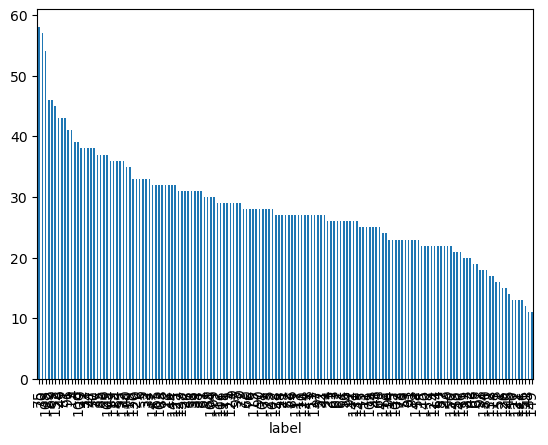

In [11]:
# label distribution
data['label'].value_counts().plot(kind='bar')

In [13]:
# load tokenizer
tokenizer = BertTokenizerFast.from_pretrained('klue/bert-base')

In [14]:
# data split
from sklearn.model_selection import train_test_split
x_tr, x_ts, y_tr, y_ts = train_test_split(data['content'],
                                          data['label'],
                                          test_size=0.2,
                                          stratify=data['label'],
                                          random_state=42)

X_train_list = x_tr.tolist()
y_train = y_tr.tolist()
X_test_list = x_ts.tolist()
y_test = y_ts.tolist()

In [16]:
# sentence tokenizing/padding
X_train = tokenizer(X_train_list, truncation=True, padding=True)
X_test = tokenizer(X_test_list, truncation=True, padding=True)

## 2. Model training

In [18]:
# 컨텐츠/레이블로 구성된 데이터셋 준비

train_dataset = tf.data.Dataset.from_tensor_slices(
    (dict(X_train), y_train)
)

val_dataset = tf.data.Dataset.from_tensor_slices(
    (dict(X_test), y_test)
)

2024-08-22 11:38:29.011127: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-22 11:38:29.031330: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-22 11:38:29.037395: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-22 11:38:29.057269: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-22 11:38:29.680618: W tensorflow/comp

In [21]:
# model compile
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

model = TFBertForSequenceClassification.from_pretrained("klue/bert-base", num_labels=153, from_pt=True)
model.compile(optimizer=optimizer, loss=model.hf_compute_loss, metrics=['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
# training

# callback_earlystop = EarlyStopping(
#     monitor="accuracy",      # val_accuracy 값의 개선이
#     patience=2,             # 2 epoch에 걸쳐 이뤄지지 않는 경우 학습을 조기 종료시킨다.
#     min_delta=0.001         # 0.001 이상 변화하지 않으면 개선되지 않는 것으로 봄
#     )

model.fit(train_dataset.shuffle(10000).batch(32),
          epochs=30,
          batch_size=32,
          validation_data=val_dataset.shuffle(10000).batch(32))

Epoch 1/30


I0000 00:00:1724294427.870152 1708022 service.cc:146] XLA service 0x7fc2b54a6c70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724294427.870193 1708022 service.cc:154]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2024-08-22 11:40:27.880149: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-22 11:40:27.932426: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1724294428.056235 1708022 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


108/108 [==============================] - 53s 169ms/step - loss: 4.9402 - accuracy: 0.0268 - val_loss: 4.6676 - val_accuracy: 0.0943
Epoch 2/30
108/108 [==============================] - 13s 124ms/step - loss: 4.2106 - accuracy: 0.3020 - val_loss: 3.8851 - val_accuracy: 0.3958
Epoch 3/30
108/108 [==============================] - 12s 114ms/step - loss: 3.2046 - accuracy: 0.6217 - val_loss: 3.0122 - val_accuracy: 0.5867
Epoch 4/30
108/108 [==============================] - 12s 110ms/step - loss: 2.1953 - accuracy: 0.8195 - val_loss: 2.2516 - val_accuracy: 0.6857
Epoch 5/30
108/108 [==============================] - 12s 108ms/step - loss: 1.3402 - accuracy: 0.9228 - val_loss: 1.6682 - val_accuracy: 0.7590
Epoch 6/30
108/108 [==============================] - 12s 109ms/step - loss: 0.7618 - accuracy: 0.9627 - val_loss: 1.2960 - val_accuracy: 0.7939
Epoch 7/30
108/108 [==============================] - 12s 111ms/step - loss: 0.4275 - accuracy: 0.9726 - val_loss: 1.0873 - val_accuracy: 0.8

## 3. Save model & inference

In [23]:
# 모델 저장
model.save_pretrained('checkpoint')
tokenizer.save_pretrained('checkpoint')

('0920GPUbert/tokenizer_config.json',
 '0920GPUbert/special_tokens_map.json',
 '0920GPUbert/vocab.txt',
 '0920GPUbert/added_tokens.json',
 '0920GPUbert/tokenizer.json')

In [ ]:
from transformers import BertTokenizerFast
from transformers import TFBertForSequenceClassification
from transformers import TextClassificationPipeline
import tensorflow as tf
import tensorflow as tf
import pandas as pd

# load model
loaded_tokenizer = BertTokenizerFast.from_pretrained('0920GPUbert') # input model directory
loaded_model = TFBertForSequenceClassification.from_pretrained('0920GPUbert') # input model directory

text_classifier = TextClassificationPipeline(tokenizer=loaded_tokenizer,
                                              model=loaded_model,
                                              framework='tf',
                                              return_all_scores=True)

Some layers from the model checkpoint at 0920GPUbert were not used when initializing TFBertForSequenceClassification: ['dropout_75']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at 0920GPUbert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:1

In [ ]:
def recommend(input_sentence):
  '''
  Function that recommends 10 menus based on the input sentence
  (with the highest scoring menu at the top)
  '''
  score_list = [i['score'] for i in text_classifier(input_sentence)[0]]
  indices_of_max_values = np.argsort(score_list)[-10:][::-1]

  menu = []
  for i in indices_of_max_values:
    menu.append(data[data['label'] == i].iloc[0]['menu'])
  return menu

In [ ]:
recommend("졸업식날 먹기 좋은 음식은 뭐야")

['짜장면', '김밥', '돈가스', '덮밥', '볶음밥', '제육볶음', '김치전', '감자전', '라볶이', '생선구이']

In [ ]:
recommend("치킨 말고 다른 튀긴 기름진 음식 추천해줘")

['닭껍질튀김', '깐풍기', '라조기', '치킨가스', '닭도리탕', '백숙', '해물탕', '족발', '치킨', '찜닭']

In [ ]:
recommend("비오는날 막걸리랑 먹기 좋은 음식 추천해줘")

['김치전', '파전', '덮밥', '해물파전', '빈대떡', '감자전', '감바스', '삼겹살', '오뎅', '꼬치']

In [ ]:
recommend("된장찌개 빼고 찌개요리 추천해줘")

['김치찌개', '내장탕', '돼지불고기', '콩나물국밥', '김치찜', '설렁탕', '청국장', '순두부', '고등어구이', '리조또']

In [ ]:
recommend("백숙 말고 다른 닭 요리 추천해줘")

['삼계탕', '깐풍기', '닭도리탕', '찜닭', '백숙', '라조기', '닭껍질튀김', '낙지볶음', '해물탕', '비빔국수']

In [ ]:
recommend("기분이 우울하고 비오는날 먹기 좋은 음식")

['파전', '감자전', '해물파전', '김치전', '연어', '잔치국수', '덮밥', '감바스', '해물탕', '메밀국수']

In [ ]:
recommend('초면인 팀원들과 먹을 점심 메뉴 추천해줘')

['김치찌개', '초밥', '난자완스', '생선구이', '순대국', '콩나물국밥', '제육볶음', '낙지볶음', '김치찜', '잔치국수']

In [ ]:
recommend('간식 먹고싶어 간식 추천해줘')

['빵', '토스트', '닭껍질튀김', '도토리묵', '족발', '추어탕', '죽', '호떡', '도가니탕', '보쌈']

In [ ]:
recommend('남자가 좋아하는 음식')

['돈가스', '순대국', '장어구이', '함박스테이크', '훠궈', '생선구이', '호떡', '김치찌개', '스파게티', '닭발']

In [ ]:
recommend('여자가 좋아하는 음식')

['훠궈', '돈가스', '닭발', '마라탕', '내장탕', '샤브샤브', '초밥', '커리', '순대', '어묵탕']

In [ ]:
recommend('어르신이 좋아하는 음식')

['함박스테이크', '호떡', '내장탕', '청국장', '김치찌개', '설렁탕', '김치찜', '콩나물국밥', '돌솥비빔밥', '족발']

In [ ]:
recommend('아이가 좋아하는 음식')

['함박스테이크', '치킨가스', '감바스', '닭도리탕', '탄탄면', '짜장밥', '내장탕', '마파두부', '김치찌개', '김치찜']

In [ ]:
recommend('햄버거나 피자 말고 기름진 거 추천해줘')

['치킨', '피자', '스테이크', '스파게티', '초밥', '햄버거', '생선구이', '연어', '물회', '돈가스']

In [ ]:
recommend('된장찌개 추천해줘')

['돼지불고기', '갈비탕', '곱창', '청국장', '잡채밥', '추어탕', '도가니탕', '내장탕', '볶음밥', '낙지볶음']